In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier

## Downloading data

In [0]:
url = "https://raw.githubusercontent.com/woldemarg/nix_solutions_test/master/task_3/data/Data%20for%20the%20Churn%20task%20_%20BDA%20homework.csv"
data = pd.read_csv(url)

data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Data cleaning

Here we perform some data cleaning (mainly transforming categorical features) in order to apply further some ML algorithms to it. 

In [0]:
data_mod = data.drop(["customerID",
                      "TotalCharges"],
                     axis=1)

binary_cols = (data_mod.columns[(data_mod.nunique() == 2) &
                                (data_mod.apply(
                                    lambda s: all(s.str.contains("Yes|No"))))]
               .tolist())

data_mod.loc[:, binary_cols] = (data_mod[binary_cols]
                                .replace(["Yes", "No"], [1, 0]))

threesome_cols = (data_mod.columns[(data_mod.nunique() == 3) &
                                   (data_mod.apply(
                                       lambda s:
                                       all(s.str.contains("Yes|No"))))]
                  .tolist())

data_mod.loc[:, threesome_cols] = (data_mod[threesome_cols]
                                   .replace({
                                       "Yes": 1,
                                       "No": 0,
                                       "No phone service": 0,
                                       "No internet service": 0}))

# ordered categorical variable
data_mod.loc[:, "InternetService"] = (data_mod.InternetService
                                      .replace({
                                          "No": 0,
                                          "DSL": 1,
                                          "Fiber optic": 2}))

In [0]:
cat_cols_left = [col for col in data_mod
                 if data_mod[col].dtype == "object"]

OH_encoder = OneHotEncoder(handle_unknown="error",
                           drop="first", sparse=False)

OH_cols = pd.DataFrame(OH_encoder.fit_transform(data_mod[cat_cols_left]))

OH_cols_names = OH_encoder.get_feature_names(cat_cols_left)
OH_cols.columns = OH_cols_names

data_num = pd.concat([data_mod.drop(cat_cols_left, axis=1), OH_cols],
                     axis=1)

data_num.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,Churn,gender_Male,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,1,0,0,1,0,1,0,0,0,0,1,29.85,0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,0,0,34,1,0,1,1,0,1,0,0,0,0,56.95,0,1.0,1.0,0.0,0.0,0.0,1.0
2,0,0,0,2,1,0,1,1,1,0,0,0,0,1,53.85,1,1.0,0.0,0.0,0.0,0.0,1.0
3,0,0,0,45,0,0,1,1,0,1,1,0,0,0,42.30,0,1.0,1.0,0.0,0.0,0.0,0.0
4,0,0,0,2,1,0,2,0,0,0,0,0,0,1,70.70,1,0.0,0.0,0.0,0.0,1.0,0.0


## Answering customer questions

### What is the average revenue per user, which has only Internet services?

In [0]:
(data_num[(data_num.PhoneService == 0) &
         (data_num.InternetService != 0)]["MonthlyCharges"]
 .agg(["min", "mean", "max"]))

min     23.450000
mean    42.028592
max     67.200000
Name: MonthlyCharges, dtype: float64

### Split these users by different types of payment

In [0]:
(data[(data.PhoneService == "No") &
         (data.InternetService != "No")]
 .groupby("PaymentMethod")["MonthlyCharges"]
 .agg(["min", "mean", "max", "count"]))

,min,mean,max,count
PaymentMethod,,,,
Bank transfer (automatic),24.10,46.131119,66.8,143
Credit card (automatic),24.35,44.860390,67.2,154
Electronic check,23.45,40.748673,64.7,226
Mailed check,24.20,37.415409,63.4,159


It is no wonder that internet users prefer to use online (automatic) methods of payment.

### Display the ratio of revenue between clients that left last month and clients that are still with us

In [0]:
(data_num
 .groupby("Churn")["MonthlyCharges"]
 .sum() / data_num["MonthlyCharges"].sum() * 100)

Churn
0    69.496648
1    30.503352
Name: MonthlyCharges, dtype: float64

It seems like our customer has lost almost one-third of its monthly revenue with churn users.

### What types of contract do prefer people that churn?

In [0]:
(data[data.Churn == "Yes"]
 .groupby("Contract")["Churn"]
 .count())

Contract
Month-to-month    1655
One year           166
Two year            48
Name: Churn, dtype: int64

As expected a vast majority of churn users were on month-to-month payment basis: easycom, easy go.

### Who brings more revenue, clients with the duration of cooperation less than 10 months, 10- 30 months, 30- 50 months, more than 50 months?

In [0]:
(data
 .assign(tenure_bins=pd.cut(data["tenure"],
                            [0, 10, 30, 50, 72], #72 is a max of tenure column
                            include_lowest=True,
                            precision=0))
 .groupby("tenure_bins")["MonthlyCharges"]
 .sum() / data["MonthlyCharges"].sum() *100)

tenure_bins
(-1, 10]    24.158538
(10, 30]    22.542964
(30, 50]    19.122007
(50, 72]    34.176491
Name: MonthlyCharges, dtype: float64

The above numbers are percents of the total monthly revenue. As we see, they are almost equal within given time ranges, exept for category 50+, which share is slightly bigger. 

## Churn rate: dive deeper
Hereafter we are going to perform deeperanalysisof churn users, based on somewhat unexpected overlapping of two ML algorithns: clustering and classification. 

## Scaling and splitting beforehand preprocessing data

In [0]:
y = data_num.Churn
X = data_num.drop(["Churn"], axis=1)

In [0]:
scaler = StandardScaler()

X_scaled = pd.DataFrame(scaler.fit_transform(X))
X_scaled.columns = X.columns

## Searching for clusters in a given dataset
We assume that churn problem is specific to a certain extend for some particular group (-s) of users. 

In [0]:
# detecting optimal numof clusters
# with the help of SH and CH scores 
sl_scores = []
ch_scores = []
k_means_res = {}

num_clusters = range(2, 11)


for k in num_clusters:
    k_means = KMeans(n_clusters=k).fit(X_scaled)

    sl_scores.append(silhouette_score(X_scaled,
                                      k_means.labels_,
                                      metric='euclidean'))

    ch_scores.append(calinski_harabasz_score(X_scaled,
                                             k_means.labels_))

    k_means_res.update({k: k_means.__dict__})

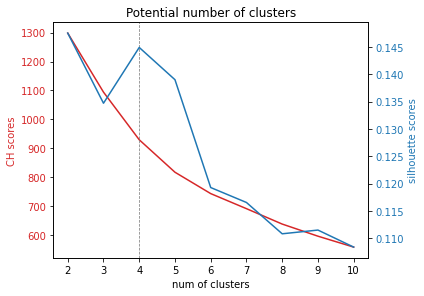

In [0]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("num of clusters")
ax1.set_ylabel("CH scores", color=color)
ax1.plot(num_clusters, ch_scores, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.axvline(x=4, linestyle="--", color="tab:grey", linewidth=0.75)
ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel("silhouette scores", color=color)
ax2.plot(num_clusters, sl_scores, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title("Potential number of clusters")
plt.show()

Based on some ML alchemy we depict 4 as the optimal num of users' clusters in our data, though it is not so obvious as we might expected.   

## Visualizing clusters in a 2D features' space (PCA-analysis) 

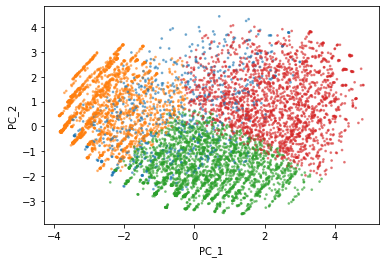

In [0]:
k_best = 4

pca = PCA(n_components=2)

principal_components = pca.fit_transform(X_scaled)

principal_df = pd.DataFrame(data=principal_components,
                            columns=["PC_1", "PC_2"])

data_pca = pd.concat([principal_df,
                      pd.Series(k_means_res[k_best]["labels_"],
                                name="cluster_labels"),
                      y], axis=1)


clusters = np.unique(data_pca.cluster_labels)
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
colors_dict = dict(zip(clusters, colors))
data_pca["cluster_colors"] = (data_pca.cluster_labels
                              .apply(lambda x: colors_dict[x]))


data_pca.plot.scatter(x="PC_1",
                      y="PC_2",
                      c=data_pca.cluster_colors,
                      s=3,
                      alpha=0.5)

## Trying to understand obtained clusters 

### Internet users
Class labels are chosen randomly by Kmeans algorithms.
Type of Internet connection as we have defined thereinbefore:
0 - no Internet
1 - DSL
2 - Fiber optic  

In [0]:
data_clusters = pd.concat([X, data_pca.cluster_labels], axis=1)

internet = (data_clusters
            .groupby(["cluster_labels", "InternetService"])
            .agg({"InternetService": "count"})
            .unstack(level=-1, fill_value=0))

internet

InternetService           
InternetService               0    1     2
cluster_labels                            
0                             0  682     0
1                          1525  473    25
2                             1  460  1908
3                             0  806  1163

As shown in table, we have two groups of "heavy" Internet users within our clusters (those with bigger numbers for "1" and "2" of InternetService). Other clients naturally fall into a group of (almost) no-Internet users (i.e. phone service subscribers) and another group of dummy "moderate" Internet-users (with DSL only). 

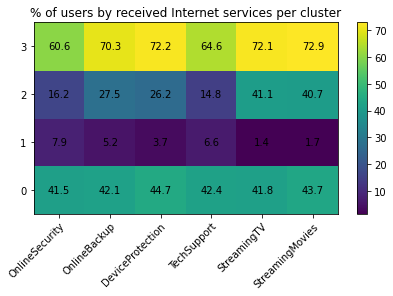

In [0]:
i_services = data_clusters.iloc[:, [7, 8, 9, 10, 11, 12, 21]]

i_services_share = (i_services
                    .groupby("cluster_labels")
                    .apply(lambda df: df.sum() / df.count() * 100)
                    .drop("cluster_labels", axis=1))


def draw_heatmap(d, x_ticks, y_ticks, title, x_label=None, y_label=None):
    fig_hm, ax = plt.subplots()
    hm = plt.pcolor(d)
    ax.set_xticks(np.arange(d.shape[1]) + 0.5)
    ax.set_yticks(np.arange(d.shape[0]) + 0.5)
    ax.set_xticklabels(x_ticks)
    ax.set_yticklabels(y_ticks)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.setp(ax.get_xticklabels(),
             rotation=45,
             ha="right",
             rotation_mode="anchor")
    for i in range(d.shape[0]):
        for j in range(d.shape[1]):
            plt.text(j + 0.5, i + 0.5, '%.1f' % d.iloc[i, j],
                     horizontalalignment='center',
                     verticalalignment='center')
    plt.colorbar(hm)
    fig_hm.tight_layout()
    ax.set_title(title)
    plt.show()


draw_heatmap(i_services_share,
             i_services_share.columns,
             range(4),
             "% of users by received Internet services per cluster")

The above heatmap suggests for a huge dissimilarity between clusters of so called "heavy" Internet users: in one group we observe far more intensive "consumption" of almost all available online services (by more than 60% of users within group on average), while another group of Internet users is notable for its members' specific interest in online streaming services.    

### Distribution (share) of monthly revenue by clusters
... in total:

In [0]:
mon_income = (data_clusters
              .groupby("cluster_labels")["MonthlyCharges"].sum()
              .apply(lambda x:
                     x / data_clusters["MonthlyCharges"].sum() * 100))
mon_income

cluster_labels
0     6.284248
1    12.836038
2    41.514790
3    39.364923
Name: MonthlyCharges, dtype: float64

... per user:

In [0]:
mon_income_avg = (data_clusters
                  .groupby("cluster_labels")["MonthlyCharges"].mean())

mon_income_avg

cluster_labels
0    42.028592
1    28.940830
2    79.930709
3    91.188395
Name: MonthlyCharges, dtype: float64

It is obvious that those "streaming-lovers" group is one of a cash cows in our client's business.

In [0]:
churn_per_cluster = (data_pca
                     .groupby(["cluster_labels", "Churn"])
                     .agg({"Churn": "count"}))

churn_per_cluster["ratio"] = (churn_per_cluster
                              .groupby(level=0)
                              .apply(lambda x:
                                     100 * x / x.sum()))

churn_per_cluster

Churn      ratio
cluster_labels Churn                  
0              0        512  75.073314
               1        170  24.926686
1              0       1787  88.334157
               1        236  11.665843
2              0       1164  49.134656
               1       1205  50.865344
3              0       1711  86.896902
               1        258  13.103098

But alas, we have a biggest churn rate in there!

## Selecting features for criss-cross analysis
What we are going to do next - is to enchane several features, that contbibuted the most to distinguishing churn and non-churn users, as well as users between clusters. 

#### Churn-classification feature importance

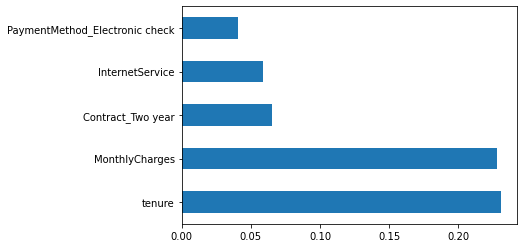

In [0]:
rf_mod = RandomForestClassifier(class_weight="balanced_subsample")

rf_mod_churn = rf_mod.fit(X, y)

f_imp_churn = pd.Series(rf_mod_churn.feature_importances_,
                        index=X.columns)


plt.figure()
f_imp_churn.nlargest(5).plot(kind="barh")
plt.show()

#### Cluster-classification feature imporatnce
To perform this we simply fed clusters labels as target feature to RF model.  

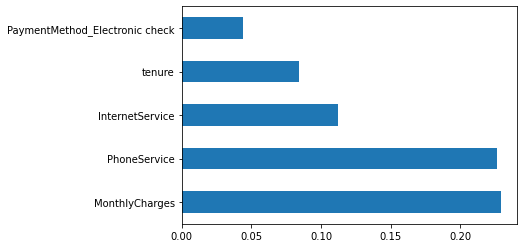

In [0]:
rf_mod_clusters = rf_mod.fit(X, data_pca["cluster_labels"])

f_imp_clusters = pd.Series(rf_mod_clusters.feature_importances_,
                           index=X.columns)


plt.figure()
f_imp_clusters.nlargest(5).plot(kind="barh")
plt.show()

Obviously, we have few features serving equally well to distinguish churn from loyal users and to separate them between clusters based on behaviour patterns. For further analysis we will consider only "MonthlyCharges" and "tenure", though in real life we should try some more combinations of top features from both models to look for insights.  

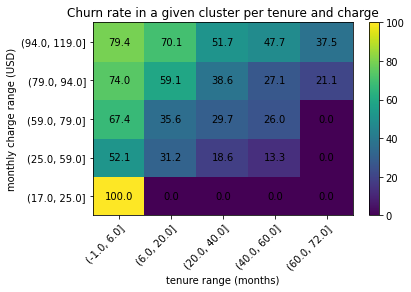

In [0]:
# transform continious features to discrete for simplicy
data_clusters["MonthlyCharges_desc"] = pd.qcut(data_clusters.MonthlyCharges,
                                              q=5,
                                              precision=0)

data_clusters["tenure_desc"] = pd.qcut(data_clusters.tenure,
                                      q=5,
                                      precision=0)

data_clusters_churn = pd.concat([data_clusters, y], axis=1)

# clusters' labels are assign by KMeans algorithm randomly,
# so we need to ensure we are dealing with the most problematic
# cluster (of "streaming-lovers" in this case) 
task_cluster = (data_clusters_churn
                .loc[data_clusters.cluster_labels == churn_per_cluster
                     .unstack(level=1)["ratio"][1]
                     .idxmax(), :])

cluster_grouped = (task_cluster
                   .groupby(["MonthlyCharges_desc",
                               "tenure_desc",
                               "Churn"])
                    .agg({"Churn": "count"})
                    .unstack(level=2))


def get_churn_ratio(row):
    row["ratio"] = row[1] / row.sum() * 100 if row[1] != 0 else 0
    return row


cluster_churn_ratio = (cluster_grouped
                       .apply(get_churn_ratio, axis=1)["ratio"]
                       .unstack(level=1))

draw_heatmap(cluster_churn_ratio,
             cluster_churn_ratio.columns,
             cluster_churn_ratio.index,
             "Churn rate in a given cluster per tenure and charge",
             "tenure range (months)",
             "monthly charge range (USD)")


There it is! What we are looking at - is the matrix of **distribution of churn rates per tenure and monthly charge ranges** for the most problematic cluster of users with the overall churn rate above 50%. The trend is quite obvious (except for odd value in the bottom left corner caused by some not-detected outliers): **the affection of new users (with the duration of cooperation for up to 6 months) to leave increases rapidly with the growth of monthly charge above 60 USD**. In other words, we can assume that this kind of users quit freely (with their month-to-month payment basis!) at the end of the promotional period or with exceeded traffic limits if any (which is quite expected concerning their addiction to online streaming). Both mentioned cases suggest increasing of monthly charges.  